In [1]:
import warnings
warnings.filterwarnings('ignore')

SEED = 42
SKIP_LENGTH = 2048
WINDOW_SIZE = 4096
OVERLAP_LENGTH = 2048
SAMPLE_RATE = 2000 # Hz
SCALING = True
# SCALING = False
# TYPE_ANOMALY_DETECTION = "Novelty"
TYPE_ANOMALY_DETECTION = "Outlier"
# TYPE_DOMAIN = "freq"
TYPE_DOMAIN = "time"


In [ ]:
# 打印出今日日期
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d'))
TODAY = datetime.datetime.now().strftime('%Y-%m-%d')

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# load X_raw_data.pkl, y_raw_data.pkl
with open("X_raw_data.pkl", "rb") as file:
    X_raw_data = pickle.load(file)

with open("y_raw_data.pkl", "rb") as file:
    y_raw_data = pickle.load(file)
    
# for arr in X_raw_data:
#     arr[:, 2] += 1000

def process_time_series_with_overlap(data, skip_length=2048, window_size=4096, overlap_length=2048):
    """
    處理 time series data，去除開頭資料並切分成固定長度、具有 overlap 的片段。
    
    :param data: numpy array, shape = (length, 3)
    :param skip_length: 開頭跳過的資料長度, 預設 2048
    :param window_size: 每段切分的長度, 預設 4096
    :param overlap_length: 每段之間的重疊長度, 預設 2048
    :return: 切分後的資料列表，每個元素為 numpy array
    """
    # 計算每次移動的步數 (window_size - overlap_length)
    step_length = window_size - overlap_length

    # 去掉開頭的資料
    data = data[skip_length:]
    
    # 切分資料，加入 overlap
    segments = [data[i:i + window_size] for i in range(0, len(data) - window_size + 1, step_length)]
    
    return segments

In [3]:
X_data = []
y_data = []

for i in range(len(X_raw_data)):
    X_data.extend(process_time_series_with_overlap(X_raw_data[i]))
    if 'good' in y_raw_data[i]:
        y_data.extend([0] * len(process_time_series_with_overlap(X_raw_data[i])))
    else:
        y_data.extend([1] * len(process_time_series_with_overlap(X_raw_data[i])))

del X_raw_data

# X_data_abs = np.abs(X_data)
# x_abs_max, y_abs_max, z_abs_max = X_data_abs[:,:,0].max(), X_data_abs[:,:,1].max(), X_data_abs[:,:,2].max()

# ## Scaling
# if SCALING:
#     for i,m_i in enumerate([x_abs_max, y_abs_max, z_abs_max]):
#         X_data[:,:,i] = X_data[:,:,i]/m_i
    
good_indices = [index for index, value in enumerate(y_data) if value == 0]
bad_indices = [index for index, value in enumerate(y_data) if value == 1]

In [4]:
X_data = np.array(X_data)
y_data = np.array(y_data)

In [5]:
# ## Scaling
if SCALING:
    # 計算每個特徵的均值和標準差
    mean = np.mean(X_data, axis=(0,1), keepdims=True)  # shape: (1, 1, 3)
    std = np.std(X_data, axis=(0,1), keepdims=True)  # shape: (1, 1, 3)

    # 進行標準化
    X_data = (X_data) / std

In [7]:
# save mean and std
np.save(f'{TODAY}-mean_std_{TYPE_DOMAIN}.npy', [mean, std])

In [8]:
# save X_data, y_data by np.save
np.save(f'{TODAY}-X_data_{TYPE_DOMAIN}.npy', X_data)
np.save(f'{TODAY}-y_data_{TYPE_DOMAIN}.npy', y_data)

In [8]:
X_data.shape, len(y_data)

((83340, 4096, 3), 83340)

In [9]:
y_data.sum()/len(y_data)

0.03080153587712983

In [10]:
X_data[0]

array([[-0.05673802,  1.38298965,  0.01712689],
       [-0.05267331,  1.65574648, -0.00557231],
       [-0.02176359,  1.44165735, -0.0352587 ],
       ...,
       [-0.14588435,  0.10469603,  0.07509945],
       [-0.13613788,  0.54478519,  0.06783984],
       [-0.00996463,  0.2753322 , -0.05027105]])

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

def encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Conv1
    x = layers.Conv1D(filters=3, kernel_size=127, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # MaxPooling1
    x = layers.MaxPooling1D(pool_size=3)(x)
    
    # Conv2
    x = layers.Conv1D(filters=3, kernel_size=11, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # MaxPooling2
    x = layers.MaxPooling1D(pool_size=3)(x)
    
    # Conv3
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # MaxPooling3
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Conv4
    x = layers.Conv1D(filters=1, kernel_size=1, padding='same')(x)
    
    # Flatten
    x = layers.Flatten()(x)
    
    # Output for encoder
    encoder_output = x
    
    # Create encoder model
    encoder_model = models.Model(inputs, encoder_output, name='encoder')
    return encoder_model

def decoder(encoded_shape):
    # Start with the encoded shape
    inputs = layers.Input(shape=(encoded_shape,))
    
    # Reshape to the last convolutional layer output shape
    x = layers.Dense(1024)(inputs)  # This should match the flattened size before Conv4
    x = layers.Reshape((1024, 1))(x)
    
    # Upsampling and Conv layers to reconstruct the original input
    x = layers.Conv1DTranspose(filters=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.UpSampling1D(size=2)(x)
    
    x = layers.Conv1DTranspose(filters=3, kernel_size=11, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.UpSampling1D(size=2)(x)
    
    x = layers.Conv1DTranspose(filters=3, kernel_size=127, padding='same')(x)
    x = layers.BatchNormalization()(x)
    # x = layers.ReLU()(x)
    outputs = x
    
    # Final output layer
    # outputs = x
    # outputs = layers.Conv1DTranspose(filters=3, kernel_size=1, padding='same')(x)
    
    # Create decoder model
    decoder_model = models.Model(inputs, outputs, name='decoder')
    return decoder_model

# Define input shape
input_shape = (4096, 3)

# Create encoder and decoder
encoder_model = encoder(input_shape)
encoded_shape = encoder_model.output_shape[1]  # Get the shape of the encoder output
decoder_model = decoder(encoded_shape)

# Create the autoencoder model
autoencoder_input = layers.Input(shape=input_shape)
encoded_output = encoder_model(autoencoder_input)
decoded_output = decoder_model(encoded_output)

autoencoder_model = models.Model(autoencoder_input, decoded_output, name='autoencoder')

# Summary of the autoencoder
autoencoder_model.summary()

2025-01-20 01:09:49.159609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 01:09:50.034106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-01-20 01:09:50.034243: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-01-20 01:09:50.034252: W tensorflow/compiler/tf2tensorrt/util

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4096, 3)]         0         
                                                                 
 encoder (Functional)        (None, 227)               2233      
                                                                 
 decoder (Functional)        (None, 4096, 3)           237269    
                                                                 
Total params: 239,502
Trainable params: 239,222
Non-trainable params: 280
_________________________________________________________________


In [12]:
# 查看 encoder 部分的摘要
encoder_model = encoder(input_shape)
encoder_model.summary()

# 查看 decoder 部分的摘要
latent_dim = encoder_model.output_shape[1]
decoder_model = decoder(latent_dim)
decoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4096, 3)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 4096, 3)           1146      
                                                                 
 batch_normalization_6 (Batc  (None, 4096, 3)          12        
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 4096, 3)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1365, 3)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1365, 3)           102 

In [13]:
len(X_data) % 128

12

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# 设置 EarlyStopping 回调
early_stopping = EarlyStopping(
    monitor='loss',          # 监控的指标，可以是 'loss' 或 'val_loss' 等
    patience=30,             # 如果连续 10 个 epoch 没有改善，则停止训练
    restore_best_weights=True,  # 在停止时恢复最好的权重
    verbose=1                # 输出早停信息
)

from tensorflow.keras.optimizers import Adam
# 編譯模型
autoencoder_model.compile(optimizer=Adam(), loss='mean_squared_error')
# 假设 X_data 是你的训练数据
history = autoencoder_model.fit(
    X_data, X_data,
    epochs=3000,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stopping]  # 添加 EarlyStopping 回调
)

2025-01-20 01:10:08.689908: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4096327680 exceeds 10% of free system memory.
2025-01-20 01:10:15.691090: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4096327680 exceeds 10% of free system memory.
2025-01-20 01:10:20.303644: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4096327680 exceeds 10% of free system memory.
2025-01-20 01:10:23.985919: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4096327680 exceeds 10% of free system memory.


Epoch 1/300


2025-01-20 01:11:01.130596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2025-01-20 01:11:01.942614: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4ad8002cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-20 01:11:01.942680: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-01-20 01:11:01.948641: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-20 01:11:02.069006: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


652/652 [==============================] - 74s 56ms/step - loss: 0.8929
Epoch 2/300
652/652 [==============================] - 37s 56ms/step - loss: 0.6552
Epoch 3/300
652/652 [==============================] - 36s 56ms/step - loss: 0.6259
Epoch 4/300
310/652 [=============>................] - ETA: 18s - loss: 0.6176

KeyboardInterrupt: 

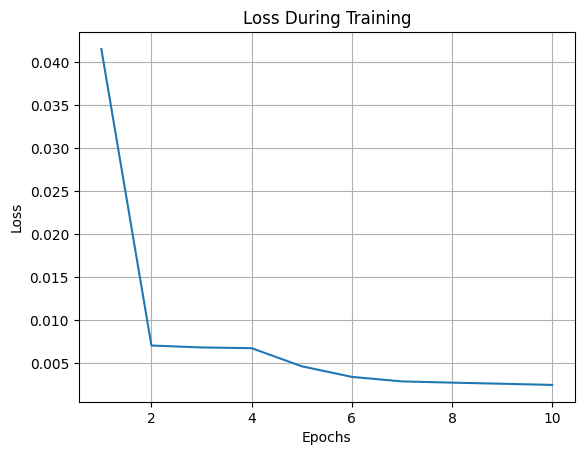

<Figure size 640x480 with 0 Axes>

In [13]:
# 获取训练过程中的 loss 值
loss_values = history.history['loss']
# 绘制损失曲线
plt.plot(range(1, len(loss_values) + 1), loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.grid(True)
plt.show()
# save the plot
plt.savefig(f'loss_plot_encode_{TYPE_DOMAIN}.png')

In [14]:
# 提取 encoder 部分
encoder_model = autoencoder_model.get_layer('encoder')

# 查看 encoder 部分的模型结构
encoder_model.summary()

X_data_encode = encoder_model.predict(X_data)
# 查看编码后的数据
print(X_data_encode)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096, 3)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4096, 3)           1146      
                                                                 
 batch_normalization (BatchN  (None, 4096, 3)          12        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4096, 3)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1365, 3)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1365, 3)           102 

2025-01-19 23:56:48.323484: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4096327680 exceeds 10% of free system memory.


2605/2605 [==============================] - 6s 2ms/step
[[ 1.1357931   1.2600672   1.1410853  ...  0.07521231 -0.63927263
   0.10421687]
 [ 0.6453032   0.66794574  0.71926254 ... 11.101378   12.649561
  10.280287  ]
 [ 0.648163    0.81354666  0.8891839  ...  0.51959884  0.5881324
   0.31169954]
 ...
 [-2.935736   -5.463349   -6.4960303  ...  8.277553    3.652892
   0.8547929 ]
 [ 2.946829    3.0669124   3.1494808  ...  3.7426362  11.145738
  10.752214  ]
 [ 2.2583938   2.0914173   1.8535408  ...  1.7194936   1.4449658
   0.8134218 ]]


In [15]:
print(X_data_encode.shape)

(83340, 227)


In [16]:
# save the encoded data
np.save(f'X_data_encode_{TYPE_DOMAIN}.npy', X_data_encode)

In [17]:
# 保存模型為 HDF5 文件
autoencoder_model.save(f'autoencoder_model_{TYPE_DOMAIN}.h5')

In [18]:
# 保存模型為 Keras 文件
autoencoder_model.save(f'autoencoder_model_{TYPE_DOMAIN}.keras')

In [ ]:
# from tensorflow.keras.models import load_model
# # 加載 Keras 格式模型
# model_keras = load_model(f'autoencoder_model_{TYPE_DOMAIN}.keras')
# model_keras.summary()


# 假設原始模型是 original_model，並且 encoder 是在原始模型中已經定義的層
# encoder = original_model.get_layer("encoder")
# 創建新模型，只包含 encoder 部分
# encoder_model = Model(inputs=original_model.input, outputs=encoder.output)